#### Spark Installation

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://apache.osuosl.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
!tar xf spark-3.3.2-bin-hadoop3.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"

In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

In [4]:
spark = SparkSession.builder.master("local[2]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

In [5]:
from pyspark import SparkContext
from pyspark import SparkConf

In [6]:
from pyspark.sql.types import *
from pyspark.sql.functions import col, split

In [7]:
import pandas as pd
from pyspark.sql.functions import min, max
from pyspark.sql.types import StringType

In [8]:
sc = spark.sparkContext

#### ELT

In [9]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.environ['Brady_Wells'] = '/content/drive/My Drive/Spark_CA'

Mounted at /content/drive


In [10]:
import time 
start_time = time.time()

In [11]:
def extract_data(start, end , path):
    with open(path) as f:
        for line in f:
            if line.startswith(start):
                result = []
                result.append(line.strip())
                for line in f:
                    if line.rstrip() == end:
                        break
                    result.append(line.strip())
    f.close()
    return(result)

In [12]:
df = spark.read.text("/content/drive/MyDrive/Spark_CA/AllBradyWells_PCA.txt")
df.show()

+--------------------+
|               value|
+--------------------+
|wellid,md,azimuth...|
|15-12,0,0,107.744...|
|15-12,1,0.001,107...|
|15-12,2,0.002,107...|
|15-12,3,0.001,107...|
|15-12,4,0.002,287...|
|15-12,5,0.005,287...|
|15-12,6,0.01,267....|
|15-12,7,0.013,264...|
|15-12,8,0.014,266...|
|15-12,9,0.013,272...|
|15-12,10,0.011,28...|
|15-12,11,0.015,31...|
|15-12,12,0.018,32...|
|15-12,13,0.019,32...|
|15-12,14,0.017,31...|
|15-12,15,0.016,28...|
|15-12,16,0.011,26...|
|15-12,17,0.009,25...|
|15-12,18,0.009,25...|
+--------------------+
only showing top 20 rows



In [13]:
path = '/content/drive/MyDrive/Spark_CA/AllBradyWells_PCA.txt'
getList = extract_data("15-12", "270.953186" , path)
getList

['15-12,0,0,107.744,327137.93,4406034.67,1244.45,NoFlow,-24.91233444,-7.05E-05,-29.7919178,0,0,0,44.09700394,28.01444817,5.091139317,0.001586914,57.29194079,287.261',
 '15-12,1,0.001,107.744,327137.93,4406034.67,1243.45,NoFlow,-24.67094803,-7.02E-05,-29.64519691,0,0,0,44.01047897,28.05720901,5.089971066,0.327758789,56.84538058,21.78198242',
 '15-12,2,0.002,107.748,327137.93,4406034.67,1242.45,NoFlow,-24.42788506,-6.99E-05,-29.49717331,0,0,0,43.97153854,28.09993362,5.088804245,1.327758789,56.39873704,21.78198242',
 '15-12,3,0.001,107.75,327137.93,4406034.67,1241.45,NoFlow,-24.18309593,-6.96E-05,-29.34780312,0,0,0,43.98332214,28.1426239,5.087639332,2.327758789,55.95206849,21.78198242',
 '15-12,4,0.002,287.737,327137.93,4406034.67,1240.45,NoFlow,-23.93653679,-6.93E-05,-29.19704247,0,0,0,44.04865265,28.18527603,5.086476326,3.327758789,55.50540156,21.78198242',
 '15-12,5,0.005,287.747,327137.93,4406034.67,1239.45,NoFlow,-23.68816185,-6.90E-05,-29.04484749,0,0,0,44.16598129,28.22789383,5.085

In [14]:
data = spark.createDataFrame(getList,StringType())
data.cache()

value
"15-12,0,0,107.744..."
"15-12,1,0.001,107..."
"15-12,2,0.002,107..."
"15-12,3,0.001,107..."
"15-12,4,0.002,287..."
"15-12,5,0.005,287..."
"15-12,6,0.01,267...."
"15-12,7,0.013,264..."
"15-12,8,0.014,266..."
"15-12,9,0.013,272..."


In [15]:
hydro_df = data.select(split(col("value"), ",").getItem(0).alias("Well_ID"),
                     split(col("value"), ",").getItem(1).alias("Depth"),
                     split(col("value"), ",").getItem(2).alias("Azimuth"),
                     split(col("value"), ",").getItem(3).alias("Inclination"),
                     split(col("value"), ",").getItem(4).alias("x"),
                     split(col("value"), ",").getItem(5).alias("y"),
                     split(col("value"), ",").getItem(6).alias("Elevation"),
                     split(col("value"), ",").getItem(7).alias("Production"),
                     split(col("value"), ",").getItem(8).alias("Normal_Change"),
                     split(col("value"), ",").getItem(9).alias("Dilation"),
                     split(col("value"), ",").getItem(10).alias("Coulomb_Stress"),
                     split(col("value"), ",").getItem(11).alias("Dilation_Tendency"),
                     split(col("value"), ",").getItem(12).alias("Slip_Tendency"),
                     split(col("value"), ",").getItem(13).alias("Curvature"),
                     split(col("value"), ",").getItem(14).alias("Model_Temp"),
                     split(col("value"), ",").getItem(15).alias("Fault_Density"),
                     split(col("value"), ",").getItem(16).alias("FaultInter_Density"),
                     split(col("value"), ",").getItem(17).alias("ContactPlane_Distance"),
                     split(col("value"), ",").getItem(18).alias("FaultPlane_Distance"),
                     split(col("value"), ",").getItem(19).alias("Vertical_Thickness")
)

hydro_df

Well_ID,Depth,Azimuth,Inclination,x,y,Elevation,Production,Normal_Change,Dilation,Coulomb_Stress,Dilation_Tendency,Slip_Tendency,Curvature,Model_Temp,Fault_Density,FaultInter_Density,ContactPlane_Distance,FaultPlane_Distance,Vertical_Thickness
15-12,0,0,107.744,327137.93,4406034.67,1244.45,NoFlow,-24.91233444,-7.05E-05,-29.7919178,0,0,0,44.09700394,28.01444817,5.091139317,0.001586914,57.29194079,287.261
15-12,1,0.001,107.744,327137.93,4406034.67,1243.45,NoFlow,-24.67094803,-7.02E-05,-29.64519691,0,0,0,44.01047897,28.05720901,5.089971066,0.327758789,56.84538058,21.78198242
15-12,2,0.002,107.748,327137.93,4406034.67,1242.45,NoFlow,-24.42788506,-6.99E-05,-29.49717331,0,0,0,43.97153854,28.09993362,5.088804245,1.327758789,56.39873704,21.78198242
15-12,3,0.001,107.75,327137.93,4406034.67,1241.45,NoFlow,-24.18309593,-6.96E-05,-29.34780312,0,0,0,43.98332214,28.1426239,5.087639332,2.327758789,55.95206849,21.78198242
15-12,4,0.002,287.737,327137.93,4406034.67,1240.45,NoFlow,-23.93653679,-6.93E-05,-29.19704247,0,0,0,44.04865265,28.18527603,5.086476326,3.327758789,55.50540156,21.78198242
15-12,5,0.005,287.747,327137.93,4406034.67,1239.45,NoFlow,-23.68816185,-6.90E-05,-29.04484749,0,0,0,44.16598129,28.22789383,5.085314751,4.327758789,55.05877617,21.78198242
15-12,6,0.01,267.66,327137.93,4406034.67,1238.45,NoFlow,-23.43792534,-6.88E-05,-28.89117622,0,0,0,44.3262558,28.27047539,5.084154606,5.327758789,54.61210989,21.78198242
15-12,7,0.013,264.599,327137.93,4406034.67,1237.45,NoFlow,-23.1857872,-6.85E-05,-28.73598671,0,0,0,44.51192093,28.31302261,5.082996368,6.327758789,54.16537615,21.78198242
15-12,8,0.014,266.393,327137.929,4406034.67,1236.45,NoFlow,-22.93178368,-6.82E-05,-28.57932472,0,0,0,44.71774292,28.3555088,5.081823349,7.327880859,53.71947083,21.78222656
15-12,9,0.013,272.536,327137.929,4406034.67,1235.45,NoFlow,-22.67571068,-6.79E-05,-28.42097855,0,0,0,44.94411087,28.397995,5.080668449,8.327880859,53.27273892,21.78222656


In [16]:
hydro_df.describe()

summary,Well_ID,Depth,Azimuth,Inclination,x,y,Elevation,Production,Normal_Change,Dilation,Coulomb_Stress,Dilation_Tendency,Slip_Tendency,Curvature,Model_Temp,Fault_Density,FaultInter_Density,ContactPlane_Distance,FaultPlane_Distance,Vertical_Thickness
count,42240,42240,42240,42240,42240,42240,42240,42240,42240,42240,42240,42240,42240,42240,42240,42240,42240,42240,42240,42240
mean,null,650.9431500473488,19.445528267045532,72.17240160984916,327525.5758350575,4406969.154423683,607.5581483428707,null,32.641608056180175,1.950759075007095...,38.28287361174676,0.2725901990338292,0.13923101459481815,2.322645651041695...,138.99828338947697,39.85790754963447,8.845654387925862,78.77983683577777,48.251861590017576,266.7541758543036
stddev,null,519.8730288823465,69.8119669846171,119.16886670682007,513.5194798127133,756.4932433242263,510.2810929867687,null,36.36149340077857,6.89628587800803E-5,26.610060954240396,0.3513100455539479,0.17748321382678522,4.262366303530199E-4,38.78144098901979,14.867559758111659,5.799757346496558,99.99770838387326,61.18638112830351,178.02310085262866
min,15-12,0,0,0,326859.34,4405124.5,-0.04,InjectionZone,-0.010577537,-0.000101174,-0.024749989,0,0,0,100.022522,0.244503036,0.00053178,0.000823975,0.001231011,0
max,MGI-2,999,9.982,99.978,328813.04,4408874.16,999.96,SecondaryProducti...,99.99008942,9.99E-07,99.99571228,1,0.4,9.99E-05,99.99801636,9.992023468,9.999703407,99.9954834,99.97996072,99.65002441


In [17]:
hydro_df.printSchema()

root
 |-- Well_ID: string (nullable = true)
 |-- Depth: string (nullable = true)
 |-- Azimuth: string (nullable = true)
 |-- Inclination: string (nullable = true)
 |-- x: string (nullable = true)
 |-- y: string (nullable = true)
 |-- Elevation: string (nullable = true)
 |-- Production: string (nullable = true)
 |-- Normal_Change: string (nullable = true)
 |-- Dilation: string (nullable = true)
 |-- Coulomb_Stress: string (nullable = true)
 |-- Dilation_Tendency: string (nullable = true)
 |-- Slip_Tendency: string (nullable = true)
 |-- Curvature: string (nullable = true)
 |-- Model_Temp: string (nullable = true)
 |-- Fault_Density: string (nullable = true)
 |-- FaultInter_Density: string (nullable = true)
 |-- ContactPlane_Distance: string (nullable = true)
 |-- FaultPlane_Distance: string (nullable = true)
 |-- Vertical_Thickness: string (nullable = true)



In [18]:
hydro_df = hydro_df.drop('ContactPlane_Distance', 'FaultPlane_Distance')
hydro_df.show()

+-------+-----+-------+-----------+----------+-----------+---------+----------+-------------+---------+--------------+-----------------+-------------+---------+-----------+-------------+------------------+------------------+
|Well_ID|Depth|Azimuth|Inclination|         x|          y|Elevation|Production|Normal_Change| Dilation|Coulomb_Stress|Dilation_Tendency|Slip_Tendency|Curvature| Model_Temp|Fault_Density|FaultInter_Density|Vertical_Thickness|
+-------+-----+-------+-----------+----------+-----------+---------+----------+-------------+---------+--------------+-----------------+-------------+---------+-----------+-------------+------------------+------------------+
|  15-12|    0|      0|    107.744| 327137.93| 4406034.67|  1244.45|    NoFlow| -24.91233444|-7.05E-05|   -29.7919178|                0|            0|        0|44.09700394|  28.01444817|       5.091139317|           287.261|
|  15-12|    1|  0.001|    107.744| 327137.93| 4406034.67|  1243.45|    NoFlow| -24.67094803|-7.02E-

In [19]:
hydro_df.groupBy('Well_ID' , 'Production').count().show()

+----------+--------------------+-----+
|   Well_ID|          Production|count|
+----------+--------------------+-----+
|     46A-1|              NoFlow|  505|
|     18A-1|              NoFlow| 1294|
|     81A-1|       InjectionZone|   35|
|      77-1|              NoFlow|  886|
|     15-12|              NoFlow| 1555|
|    18D-31|              NoFlow|  166|
|     56B-1|SecondaryProducti...|   15|
|      56-1|SecondaryProducti...|   15|
|     46A-1|SecondaryProducti...|   15|
|    18B-31|              NoFlow|  195|
|     27A-1|PrimaryProduction...|   45|
|     56B-1|              NoFlow|  346|
|     18A-1|       InjectionZone|   15|
|      18-1|SecondaryProducti...|   38|
|      64-1|              NoFlow|  896|
|     17-31|              NoFlow|  337|
|     47A-1|SecondaryProducti...|   70|
|82A-11-RD1|              NoFlow| 1874|
|      18-1|              NoFlow| 1710|
|     81B-1|              NoFlow|    1|
+----------+--------------------+-----+
only showing top 20 rows



In [20]:
hydro_df.createOrReplaceTempView("temp")
Production_df = spark.sql("select Production, Coulomb_Stress from temp where Production != 'NoFlow'")
Production_df

Production,Coulomb_Stress
SecondaryProducti...,52.64233017
SecondaryProducti...,52.65607452
SecondaryProducti...,52.66958237
SecondaryProducti...,52.68286514
SecondaryProducti...,52.69591904
SecondaryProducti...,52.70874405
SecondaryProducti...,52.72135162
SecondaryProducti...,52.73373413
SecondaryProducti...,52.74589539
SecondaryProducti...,52.7578392


In [21]:
spark.sql("select count(*) as total_count from temp").show()

+-----------+
|total_count|
+-----------+
|      42240|
+-----------+



In [22]:
res = Production_df.groupBy("Production").count().orderBy('count', ascending=False).show(10)
res

+--------------------+-----+
|          Production|count|
+--------------------+-----+
|PrimaryProduction...|  199|
|       InjectionZone|  184|
|SecondaryProducti...|  183|
+--------------------+-----+



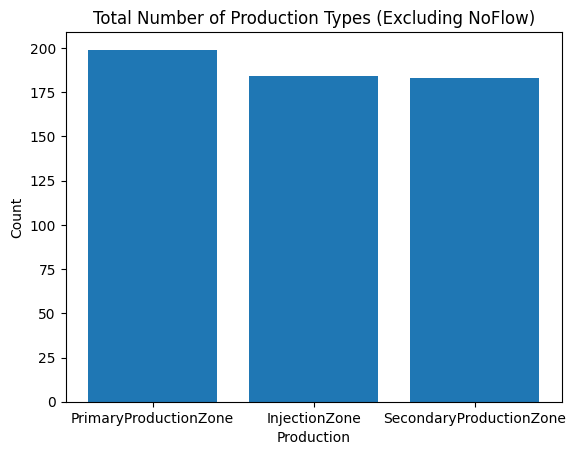

In [23]:
import matplotlib.pyplot as plt


labels = [row['Production'] for row in Production_df.groupBy("Production").count().orderBy('count', ascending=False).take(10)]
values = [row['count'] for row in Production_df.groupBy("Production").count().orderBy('count', ascending=False).take(10)]



plt.bar(labels, values)
plt.title('Total Number of Production Types (Excluding NoFlow)')
plt.xlabel('Production')
plt.ylabel('Count')
plt.show()

In [24]:
Production_depth = spark.sql("""SELECT Production, AVG(Depth) AS Depth FROM temp
          WHERE Production != 'NoFlow' GROUP BY Production""")
Production_depth

Production,Depth
PrimaryProduction...,978.8433618090454
InjectionZone,240.91208695652173
SecondaryProducti...,751.4890710382514


In [25]:
Production_depth.printSchema()

root
 |-- Production: string (nullable = true)
 |-- Depth: double (nullable = true)



In [26]:
Production_depth=Production_depth.withColumn('Depth',Production_depth['Depth'].cast("float").alias('Depth'))

In [27]:
def pieplot(Production_depth, col, lim=10, yname=None):

    classes = Production_depth.groupBy(col).count().orderBy('count', ascending=False)
    
    pd_df = classes.limit(lim).toPandas()
    
    pd_df.plot(kind='pie', x=col, y='Depth', \
           labels= ['Primary Production Zone', 'Injection Zone', 'Secondary Production Zone'], legend=False)
    plt.ylabel(None)
    plt.show()

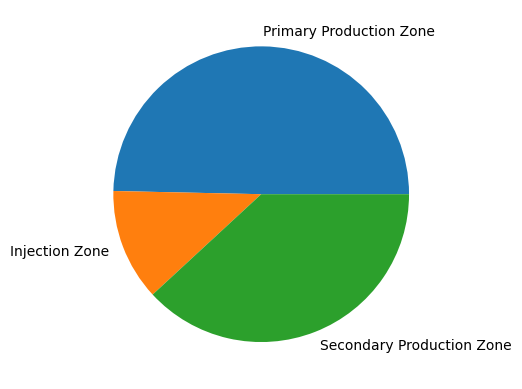

In [28]:
pieplot(Production_depth, 'Depth')

In [29]:
depth_df = spark.sql("""SELECT Production, Coulomb_Stress, Depth FROM temp
          WHERE Production = 'PrimaryProductionZone'""")
depth_df

Production,Coulomb_Stress,Depth
PrimaryProduction...,48.15366364,1754.998
PrimaryProduction...,48.20904922,1756
PrimaryProduction...,48.26437378,1757
PrimaryProduction...,48.31987381,1758
PrimaryProduction...,48.37521744,1759
PrimaryProduction...,48.43070984,1759.999
PrimaryProduction...,48.48633957,1761
PrimaryProduction...,48.54183197,1762
PrimaryProduction...,48.59734726,1763
PrimaryProduction...,48.65300751,1764


In [30]:
def lineplot(depth_df, Depth, Coulomb_Stress, measure='mean'):
    
    if measure == 'mean':
        
        pd_df = depth_df.groupBy('Depth').mean('Coulomb_Stress').toPandas().sort_values(by='Depth')
         
        pd_df.plot('Depth', 'avg({})'.format('Coulomb_Stress'), legend=False)
        
    elif measure == 'total':
        pd_df = depth_df.groupBy('Depth').sum('Coulomb_Stress').toPandas().sort_values(by='Depth')
        pd_df.plot('Depth', 'sum({})'.format('Coulomb_Stress'), legend=False)
        
    elif measure == 'count':
        pd_df = depth_df.groupBy('Depth').count().toPandas().sort_values(by='Depth')
        pd_df.plot('Depth', 'count', legend=False)
    
    plt.ylabel('Coulomb_Stress')
    plt.show()

In [31]:
depth_df=depth_df.withColumn('Depth',depth_df['Depth'].cast("float").alias('Depth'))
depth_df=depth_df.withColumn('Coulomb_Stress',depth_df['Coulomb_Stress'].cast("float").alias('Coulomb_Stress'))

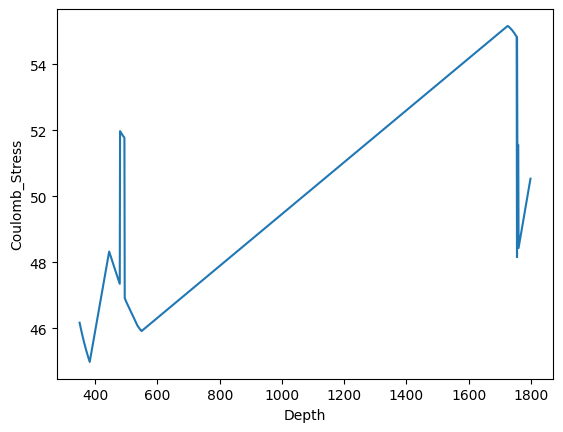

In [32]:
lineplot(depth_df, 'Depth', 'Coulomb_Stress', measure='mean')

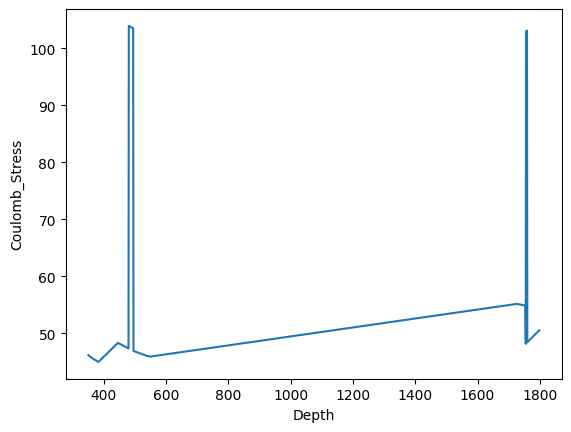

In [33]:
lineplot(depth_df, 'Depth', 'Coulomb_Stress', measure='total')

In [34]:
hydro_df.select(min(col('Coulomb_Stress')), max(col('Coulomb_Stress'))).show()

+-------------------+-------------------+
|min(Coulomb_Stress)|max(Coulomb_Stress)|
+-------------------+-------------------+
|       -0.024749989|        99.99571228|
+-------------------+-------------------+



In [35]:
end_time = time.time()
two_cores = end_time - start_time
print('Time taken with 2 cores is', end_time - start_time)

Time taken with 2 cores is 24.188090562820435


#### 4 Cores

In [36]:
spark = SparkSession.builder.master("local[4]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

In [37]:
sc = spark.sparkContext

In [38]:
start_time = time.time()

In [39]:
def extract_data(start, end , path):
    with open(path) as f:
        for line in f:
            if line.startswith(start):
                result = []
                result.append(line.strip())
                for line in f:
                    if line.rstrip() == end:
                        break
                    result.append(line.strip())
    f.close()
    return(result)

In [40]:
df = spark.read.text("/content/drive/MyDrive/Spark_CA/AllBradyWells_PCA.txt")
df.show()

+--------------------+
|               value|
+--------------------+
|wellid,md,azimuth...|
|15-12,0,0,107.744...|
|15-12,1,0.001,107...|
|15-12,2,0.002,107...|
|15-12,3,0.001,107...|
|15-12,4,0.002,287...|
|15-12,5,0.005,287...|
|15-12,6,0.01,267....|
|15-12,7,0.013,264...|
|15-12,8,0.014,266...|
|15-12,9,0.013,272...|
|15-12,10,0.011,28...|
|15-12,11,0.015,31...|
|15-12,12,0.018,32...|
|15-12,13,0.019,32...|
|15-12,14,0.017,31...|
|15-12,15,0.016,28...|
|15-12,16,0.011,26...|
|15-12,17,0.009,25...|
|15-12,18,0.009,25...|
+--------------------+
only showing top 20 rows



In [41]:
path = '/content/drive/MyDrive/Spark_CA/AllBradyWells_PCA.txt'
getList = extract_data("15-12", "270.953186" , path)
getList

['15-12,0,0,107.744,327137.93,4406034.67,1244.45,NoFlow,-24.91233444,-7.05E-05,-29.7919178,0,0,0,44.09700394,28.01444817,5.091139317,0.001586914,57.29194079,287.261',
 '15-12,1,0.001,107.744,327137.93,4406034.67,1243.45,NoFlow,-24.67094803,-7.02E-05,-29.64519691,0,0,0,44.01047897,28.05720901,5.089971066,0.327758789,56.84538058,21.78198242',
 '15-12,2,0.002,107.748,327137.93,4406034.67,1242.45,NoFlow,-24.42788506,-6.99E-05,-29.49717331,0,0,0,43.97153854,28.09993362,5.088804245,1.327758789,56.39873704,21.78198242',
 '15-12,3,0.001,107.75,327137.93,4406034.67,1241.45,NoFlow,-24.18309593,-6.96E-05,-29.34780312,0,0,0,43.98332214,28.1426239,5.087639332,2.327758789,55.95206849,21.78198242',
 '15-12,4,0.002,287.737,327137.93,4406034.67,1240.45,NoFlow,-23.93653679,-6.93E-05,-29.19704247,0,0,0,44.04865265,28.18527603,5.086476326,3.327758789,55.50540156,21.78198242',
 '15-12,5,0.005,287.747,327137.93,4406034.67,1239.45,NoFlow,-23.68816185,-6.90E-05,-29.04484749,0,0,0,44.16598129,28.22789383,5.085

In [42]:
data = spark.createDataFrame(getList,StringType())
data.cache()

value
"15-12,0,0,107.744..."
"15-12,1,0.001,107..."
"15-12,2,0.002,107..."
"15-12,3,0.001,107..."
"15-12,4,0.002,287..."
"15-12,5,0.005,287..."
"15-12,6,0.01,267...."
"15-12,7,0.013,264..."
"15-12,8,0.014,266..."
"15-12,9,0.013,272..."


In [43]:
hydro_df = data.select(split(col("value"), ",").getItem(0).alias("Well_ID"),
                     split(col("value"), ",").getItem(1).alias("Depth"),
                     split(col("value"), ",").getItem(2).alias("Azimuth"),
                     split(col("value"), ",").getItem(3).alias("Inclination"),
                     split(col("value"), ",").getItem(4).alias("x"),
                     split(col("value"), ",").getItem(5).alias("y"),
                     split(col("value"), ",").getItem(6).alias("Elevation"),
                     split(col("value"), ",").getItem(7).alias("Production"),
                     split(col("value"), ",").getItem(8).alias("Normal_Change"),
                     split(col("value"), ",").getItem(9).alias("Dilation"),
                     split(col("value"), ",").getItem(10).alias("Coulomb_Stress"),
                     split(col("value"), ",").getItem(11).alias("Dilation_Tendency"),
                     split(col("value"), ",").getItem(12).alias("Slip_Tendency"),
                     split(col("value"), ",").getItem(13).alias("Curvature"),
                     split(col("value"), ",").getItem(14).alias("Model_Temp"),
                     split(col("value"), ",").getItem(15).alias("Fault_Density"),
                     split(col("value"), ",").getItem(16).alias("FaultInter_Density"),
                     split(col("value"), ",").getItem(17).alias("ContactPlane_Distance"),
                     split(col("value"), ",").getItem(18).alias("FaultPlane_Distance"),
                     split(col("value"), ",").getItem(19).alias("Vertical_Thickness")
)

hydro_df

Well_ID,Depth,Azimuth,Inclination,x,y,Elevation,Production,Normal_Change,Dilation,Coulomb_Stress,Dilation_Tendency,Slip_Tendency,Curvature,Model_Temp,Fault_Density,FaultInter_Density,ContactPlane_Distance,FaultPlane_Distance,Vertical_Thickness
15-12,0,0,107.744,327137.93,4406034.67,1244.45,NoFlow,-24.91233444,-7.05E-05,-29.7919178,0,0,0,44.09700394,28.01444817,5.091139317,0.001586914,57.29194079,287.261
15-12,1,0.001,107.744,327137.93,4406034.67,1243.45,NoFlow,-24.67094803,-7.02E-05,-29.64519691,0,0,0,44.01047897,28.05720901,5.089971066,0.327758789,56.84538058,21.78198242
15-12,2,0.002,107.748,327137.93,4406034.67,1242.45,NoFlow,-24.42788506,-6.99E-05,-29.49717331,0,0,0,43.97153854,28.09993362,5.088804245,1.327758789,56.39873704,21.78198242
15-12,3,0.001,107.75,327137.93,4406034.67,1241.45,NoFlow,-24.18309593,-6.96E-05,-29.34780312,0,0,0,43.98332214,28.1426239,5.087639332,2.327758789,55.95206849,21.78198242
15-12,4,0.002,287.737,327137.93,4406034.67,1240.45,NoFlow,-23.93653679,-6.93E-05,-29.19704247,0,0,0,44.04865265,28.18527603,5.086476326,3.327758789,55.50540156,21.78198242
15-12,5,0.005,287.747,327137.93,4406034.67,1239.45,NoFlow,-23.68816185,-6.90E-05,-29.04484749,0,0,0,44.16598129,28.22789383,5.085314751,4.327758789,55.05877617,21.78198242
15-12,6,0.01,267.66,327137.93,4406034.67,1238.45,NoFlow,-23.43792534,-6.88E-05,-28.89117622,0,0,0,44.3262558,28.27047539,5.084154606,5.327758789,54.61210989,21.78198242
15-12,7,0.013,264.599,327137.93,4406034.67,1237.45,NoFlow,-23.1857872,-6.85E-05,-28.73598671,0,0,0,44.51192093,28.31302261,5.082996368,6.327758789,54.16537615,21.78198242
15-12,8,0.014,266.393,327137.929,4406034.67,1236.45,NoFlow,-22.93178368,-6.82E-05,-28.57932472,0,0,0,44.71774292,28.3555088,5.081823349,7.327880859,53.71947083,21.78222656
15-12,9,0.013,272.536,327137.929,4406034.67,1235.45,NoFlow,-22.67571068,-6.79E-05,-28.42097855,0,0,0,44.94411087,28.397995,5.080668449,8.327880859,53.27273892,21.78222656


In [44]:
hydro_df.describe()

summary,Well_ID,Depth,Azimuth,Inclination,x,y,Elevation,Production,Normal_Change,Dilation,Coulomb_Stress,Dilation_Tendency,Slip_Tendency,Curvature,Model_Temp,Fault_Density,FaultInter_Density,ContactPlane_Distance,FaultPlane_Distance,Vertical_Thickness
count,42240,42240,42240,42240,42240,42240,42240,42240,42240,42240,42240,42240,42240,42240,42240,42240,42240,42240,42240,42240
mean,null,650.9431500473488,19.445528267045532,72.17240160984916,327525.5758350575,4406969.154423683,607.5581483428707,null,32.641608056180175,1.950759075007095...,38.28287361174676,0.2725901990338292,0.13923101459481815,2.322645651041695...,138.99828338947697,39.85790754963447,8.845654387925862,78.77983683577777,48.251861590017576,266.7541758543036
stddev,null,519.8730288823465,69.8119669846171,119.16886670682007,513.5194798127133,756.4932433242263,510.2810929867687,null,36.36149340077857,6.89628587800803E-5,26.610060954240396,0.3513100455539479,0.17748321382678522,4.262366303530199E-4,38.78144098901979,14.867559758111659,5.799757346496558,99.99770838387326,61.18638112830351,178.02310085262866
min,15-12,0,0,0,326859.34,4405124.5,-0.04,InjectionZone,-0.010577537,-0.000101174,-0.024749989,0,0,0,100.022522,0.244503036,0.00053178,0.000823975,0.001231011,0
max,MGI-2,999,9.982,99.978,328813.04,4408874.16,999.96,SecondaryProducti...,99.99008942,9.99E-07,99.99571228,1,0.4,9.99E-05,99.99801636,9.992023468,9.999703407,99.9954834,99.97996072,99.65002441


In [45]:
hydro_df.printSchema()

root
 |-- Well_ID: string (nullable = true)
 |-- Depth: string (nullable = true)
 |-- Azimuth: string (nullable = true)
 |-- Inclination: string (nullable = true)
 |-- x: string (nullable = true)
 |-- y: string (nullable = true)
 |-- Elevation: string (nullable = true)
 |-- Production: string (nullable = true)
 |-- Normal_Change: string (nullable = true)
 |-- Dilation: string (nullable = true)
 |-- Coulomb_Stress: string (nullable = true)
 |-- Dilation_Tendency: string (nullable = true)
 |-- Slip_Tendency: string (nullable = true)
 |-- Curvature: string (nullable = true)
 |-- Model_Temp: string (nullable = true)
 |-- Fault_Density: string (nullable = true)
 |-- FaultInter_Density: string (nullable = true)
 |-- ContactPlane_Distance: string (nullable = true)
 |-- FaultPlane_Distance: string (nullable = true)
 |-- Vertical_Thickness: string (nullable = true)



In [46]:
hydro_df = hydro_df.drop('ContactPlane_Distance', 'FaultPlane_Distance')
hydro_df.show()

+-------+-----+-------+-----------+----------+-----------+---------+----------+-------------+---------+--------------+-----------------+-------------+---------+-----------+-------------+------------------+------------------+
|Well_ID|Depth|Azimuth|Inclination|         x|          y|Elevation|Production|Normal_Change| Dilation|Coulomb_Stress|Dilation_Tendency|Slip_Tendency|Curvature| Model_Temp|Fault_Density|FaultInter_Density|Vertical_Thickness|
+-------+-----+-------+-----------+----------+-----------+---------+----------+-------------+---------+--------------+-----------------+-------------+---------+-----------+-------------+------------------+------------------+
|  15-12|    0|      0|    107.744| 327137.93| 4406034.67|  1244.45|    NoFlow| -24.91233444|-7.05E-05|   -29.7919178|                0|            0|        0|44.09700394|  28.01444817|       5.091139317|           287.261|
|  15-12|    1|  0.001|    107.744| 327137.93| 4406034.67|  1243.45|    NoFlow| -24.67094803|-7.02E-

In [47]:
hydro_df.groupBy('Well_ID' , 'Production').count().show()

+----------+--------------------+-----+
|   Well_ID|          Production|count|
+----------+--------------------+-----+
|     46A-1|              NoFlow|  505|
|     18A-1|              NoFlow| 1294|
|     81A-1|       InjectionZone|   35|
|      77-1|              NoFlow|  886|
|     15-12|              NoFlow| 1555|
|    18D-31|              NoFlow|  166|
|     56B-1|SecondaryProducti...|   15|
|      56-1|SecondaryProducti...|   15|
|     46A-1|SecondaryProducti...|   15|
|    18B-31|              NoFlow|  195|
|     27A-1|PrimaryProduction...|   45|
|     56B-1|              NoFlow|  346|
|     18A-1|       InjectionZone|   15|
|      18-1|SecondaryProducti...|   38|
|      64-1|              NoFlow|  896|
|     17-31|              NoFlow|  337|
|     47A-1|SecondaryProducti...|   70|
|82A-11-RD1|              NoFlow| 1874|
|      18-1|              NoFlow| 1710|
|     81B-1|              NoFlow|    1|
+----------+--------------------+-----+
only showing top 20 rows



In [48]:
hydro_df.createOrReplaceTempView("temp")
Production_df = spark.sql("select Production, Coulomb_Stress from temp where Production != 'NoFlow'")
Production_df

Production,Coulomb_Stress
SecondaryProducti...,52.64233017
SecondaryProducti...,52.65607452
SecondaryProducti...,52.66958237
SecondaryProducti...,52.68286514
SecondaryProducti...,52.69591904
SecondaryProducti...,52.70874405
SecondaryProducti...,52.72135162
SecondaryProducti...,52.73373413
SecondaryProducti...,52.74589539
SecondaryProducti...,52.7578392


In [49]:
spark.sql("select count(*) as total_count from temp").show()

+-----------+
|total_count|
+-----------+
|      42240|
+-----------+



In [50]:
res = Production_df.groupBy("Production").count().orderBy('count', ascending=False).show(10)
res

+--------------------+-----+
|          Production|count|
+--------------------+-----+
|PrimaryProduction...|  199|
|       InjectionZone|  184|
|SecondaryProducti...|  183|
+--------------------+-----+



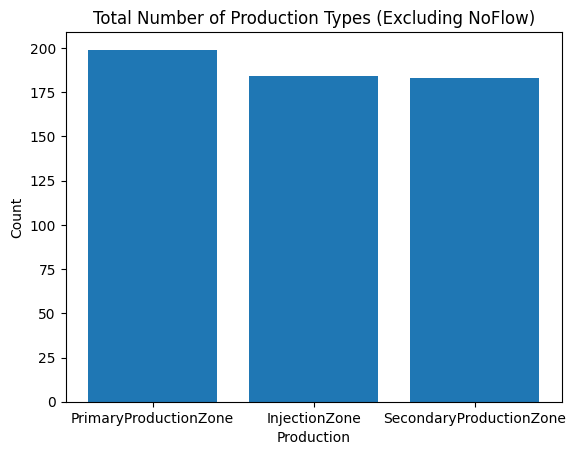

In [51]:
import matplotlib.pyplot as plt


labels = [row['Production'] for row in Production_df.groupBy("Production").count().orderBy('count', ascending=False).take(10)]
values = [row['count'] for row in Production_df.groupBy("Production").count().orderBy('count', ascending=False).take(10)]



plt.bar(labels, values)
plt.title('Total Number of Production Types (Excluding NoFlow)')
plt.xlabel('Production')
plt.ylabel('Count')
plt.show()

In [52]:
Production_depth = spark.sql("""SELECT Production, AVG(Depth) AS Depth FROM temp
          WHERE Production != 'NoFlow' GROUP BY Production""")
Production_depth

Production,Depth
PrimaryProduction...,978.8433618090454
InjectionZone,240.91208695652173
SecondaryProducti...,751.4890710382514


In [53]:
Production_depth.printSchema()

root
 |-- Production: string (nullable = true)
 |-- Depth: double (nullable = true)



In [54]:
Production_depth=Production_depth.withColumn('Depth',Production_depth['Depth'].cast("float").alias('Depth'))

In [55]:
def pieplot(Production_depth, col, lim=10, yname=None):

    classes = Production_depth.groupBy(col).count().orderBy('count', ascending=False)
    
    pd_df = classes.limit(lim).toPandas()
    
    pd_df.plot(kind='pie', x=col, y='Depth', \
           labels= ['Primary Production Zone', 'Injection Zone', 'Secondary Production Zone'], legend=False)
    plt.ylabel(None)
    plt.show()

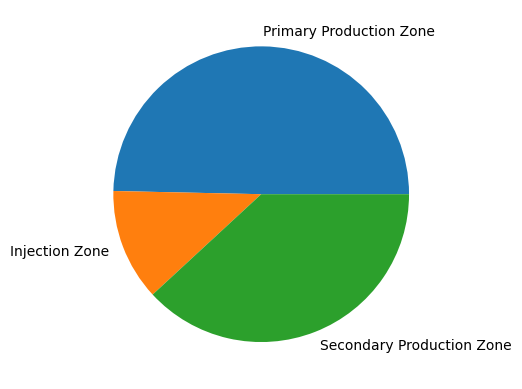

In [56]:
pieplot(Production_depth, 'Depth')

In [57]:
depth_df = spark.sql("""SELECT Production, Coulomb_Stress, Depth FROM temp
          WHERE Production = 'PrimaryProductionZone'""")
depth_df

Production,Coulomb_Stress,Depth
PrimaryProduction...,48.15366364,1754.998
PrimaryProduction...,48.20904922,1756
PrimaryProduction...,48.26437378,1757
PrimaryProduction...,48.31987381,1758
PrimaryProduction...,48.37521744,1759
PrimaryProduction...,48.43070984,1759.999
PrimaryProduction...,48.48633957,1761
PrimaryProduction...,48.54183197,1762
PrimaryProduction...,48.59734726,1763
PrimaryProduction...,48.65300751,1764


In [58]:
def lineplot(depth_df, Depth, Coulomb_Stress, measure='mean'):
    
    if measure == 'mean':
        
        pd_df = depth_df.groupBy('Depth').mean('Coulomb_Stress').toPandas().sort_values(by='Depth')
        
        pd_df.plot('Depth', 'avg({})'.format('Coulomb_Stress'), legend=False)
        
    elif measure == 'total':
        pd_df = depth_df.groupBy('Depth').sum('Coulomb_Stress').toPandas().sort_values(by='Depth')
        pd_df.plot('Depth', 'sum({})'.format('Coulomb_Stress'), legend=False)
        
    elif measure == 'count':
        pd_df = depth_df.groupBy('Depth').count().toPandas().sort_values(by='Depth')
        pd_df.plot('Depth', 'count', legend=False)
    
    plt.xlabel('Depth (m)')
    plt.ylabel('Coulomb Stress (MPa)')
    plt.show()

In [59]:
depth_df=depth_df.withColumn('Depth',depth_df['Depth'].cast("float").alias('Depth'))
depth_df=depth_df.withColumn('Coulomb_Stress',depth_df['Coulomb_Stress'].cast("float").alias('Coulomb_Stress'))

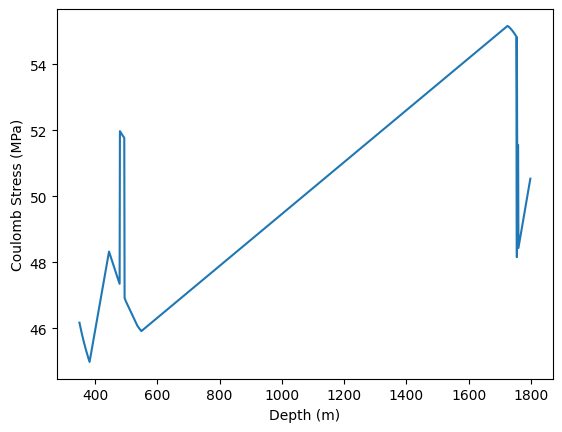

In [60]:
lineplot(depth_df, 'Depth', 'Coulomb_Stress', measure='mean')

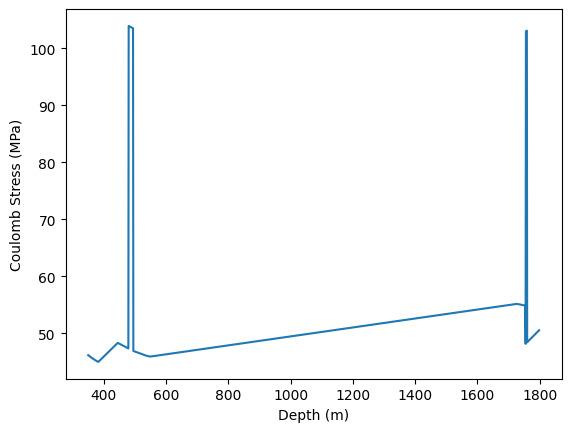

In [61]:
lineplot(depth_df, 'Depth', 'Coulomb_Stress', measure='total')

In [62]:
hydro_df.select(min(col('Coulomb_Stress')), max(col('Coulomb_Stress'))).show()

+-------------------+-------------------+
|min(Coulomb_Stress)|max(Coulomb_Stress)|
+-------------------+-------------------+
|       -0.024749989|        99.99571228|
+-------------------+-------------------+



In [63]:
end_time = time.time()
four_cores = end_time - start_time
print('Time taken with 4 cores is', end_time - start_time)

Time taken with 4 cores is 11.391876459121704


###Time Analysis

In [64]:
two_cores

24.188090562820435

In [65]:
four_cores

11.391876459121704

In [66]:
time_df = two_cores, four_cores
time_df

(24.188090562820435, 11.391876459121704)

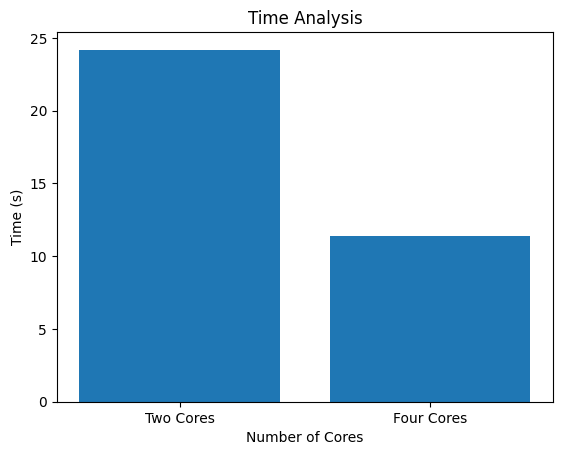

In [67]:
Cores = ['Two Cores','Four Cores']
Time = [two_cores, four_cores]

plt.bar(Cores, Time)
plt.title('Time Analysis')
plt.xlabel('Number of Cores')
plt.ylabel('Time (s)')
plt.show()